# 🏦 Projet Fil Rouge – Système de Trading GBP/USD
## Tâches T02 · T04 · T06 · T08

**Auteur** : LudovicPicard  
**Paire** : GBP/USD  
**Fréquence** : M15 (15 minutes)  
**Données** : 2022 (Train) · 2023 (Validation) · 2024 (Test)

---

### Sommaire
1. [Setup & Imports](#1)
2. [T02 – Agrégation M1 → M15](#2)
3. [T04 – Analyse exploratoire](#3)
4. [T06 – Baselines & Backtest](#4)
5. [T08 – Reinforcement Learning](#5)

## 1. Setup & Imports <a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from scipy import stats as sp_stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Config graphique
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 120

# Chemins
PROJECT_ROOT = Path('.').resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))
print(f'📁 Projet : {PROJECT_ROOT}')

# Constantes
YEARS = [2022, 2023, 2024]
LABELS = {2022: '🟦 Train', 2023: '🟧 Validation', 2024: '🟩 Test'}
COLORS = {2022: 'steelblue', 2023: 'darkorange', 2024: 'green'}

📁 Projet : C:\Users\JC\Documents\Sup_de_vinci\M2\Datascience\Projet_final


---
## 2. T02 – Agrégation M1 → M15 <a id='2'></a>

### Objectif
Transformer les données brutes **1 minute** en bougies **15 minutes** en respectant les règles imposées :
- `open_15m` = open de la **1ère minute** du bloc
- `high_15m` = **max(high)** sur 15 minutes
- `low_15m` = **min(low)** sur 15 minutes
- `close_15m` = close de la **dernière minute** du bloc

> ⚠️ Aucune modélisation n'est autorisée en M1. L'agrégation est la première étape obligatoire.

### 2.1 Aperçu des données brutes M1

In [2]:
# Charger un échantillon des données brutes M1 pour chaque année
cols_m1 = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']

m1_files = {
    2022: PROJECT_ROOT / 'HISTDATA_COM_MT_GBPUSD_M12022' / 'DAT_MT_GBPUSD_M1_2022.csv',
    2023: PROJECT_ROOT / 'HISTDATA_COM_MT_GBPUSD_M12023' / 'DAT_MT_GBPUSD_M1_2023.csv',
    2024: PROJECT_ROOT / 'HISTDATA_COM_MT_GBPUSD_M12024' / 'DAT_MT_GBPUSD_M1_2024.csv',
}

for year, path in m1_files.items():
    df_m1 = pd.read_csv(path, header=None, names=cols_m1)
    print(f'\n📅 {year} ({LABELS[year]}) : {len(df_m1):,} lignes M1')
    print(f'   Période : {df_m1["date"].iloc[0]} → {df_m1["date"].iloc[-1]}')
    display(df_m1.head(3))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\JC\\Documents\\Sup_de_vinci\\M2\\Datascience\\Projet_final\\HISTDATA_COM_MT_GBPUSD_M12022\\DAT_MT_GBPUSD_M1_2022.csv'

In [ ]:
def load_and_clean_m1(path):
    cols = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
    df = pd.read_csv(path, header=None, names=cols)

    # Construction du timestamp
    df['timestamp'] = pd.to_datetime(
        df['date'] + ' ' + df['time'],
        format='%Y.%m.%d %H:%M'
    )

    df = (
        df
        .set_index('timestamp')
        .sort_index()
    )

    # Suppression des doublons M1 (clé = timestamp)
    df = df[~df.index.duplicated(keep='first')]

    return df

In [ ]:
def m1_to_m15(df_m1):
    grouped = df_m1.resample('15T')

    m15 = grouped.agg(
        open_15m  = ('open',  'first'),
        high_15m  = ('high',  'max'),
        low_15m   = ('low',   'min'),
        close_15m = ('close', 'last'),
        volume    = ('volume','sum'),
        tick_count= ('close', 'count')
    )

    # 🔥 Suppression des bougies M15 incomplètes
    m15 = m15[m15['tick_count'] == 15]

    return m15


In [ ]:
m15 = {}

for year, path in m1_files.items():
    if not path.exists():
        print(f"[SKIP] {year} introuvable")
        continue

    df_m1 = load_and_clean_m1(path)
    df_m15 = m1_to_m15(df_m1)

    m15[year] = df_m15

    print(f"✅ {year} : {len(df_m15):,} bougies M15 générées")

out = PROJECT_ROOT / "data" / "m15"
out.mkdir(exist_ok=True)

for year, df in m15.items():
    df.to_csv(out / f"GBPUSD_M15_{year}.csv")


In [ ]:
df_m15 = df_m15.dropna()

### 2.2 Résultat de l'agrégation M15

In [ ]:
# Charger les données M15 agrégées (output de T02)
m15 = {}
for year in YEARS:
    path = PROJECT_ROOT / 'data' / 'm15' / f'GBPUSD_M15_{year}.csv'
    m15[year] = pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
    print(f'✅ {year} ({LABELS[year]}) : {len(m15[year]):,} bougies M15')

print(f'\n📊 Colonnes : {list(m15[2022].columns)}')
print(f'\n--- Exemple de données M15 (2022) ---')
display(m15[2022].head(10))

✅ 2022 (🟦 Train) : 24,947 bougies M15
✅ 2023 (🟧 Validation) : 21,572 bougies M15
✅ 2024 (🟩 Test) : 24,968 bougies M15

📊 Colonnes : ['open_15m', 'high_15m', 'low_15m', 'close_15m', 'volume', 'tick_count']

--- Exemple de données M15 (2022) ---


,open_15m,high_15m,low_15m,close_15m,volume,tick_count
timestamp,,,,,,
2022-01-02 17:00:00,1.35199,1.35233,1.35199,1.35223,0,8
2022-01-02 17:15:00,1.35231,1.35253,1.35223,1.35241,0,9
2022-01-02 17:30:00,1.35223,1.35323,1.35223,1.35295,0,14
2022-01-02 17:45:00,1.35292,1.35319,1.35260,1.35269,0,15
2022-01-02 18:00:00,1.35287,1.35338,1.35257,1.35258,0,15
2022-01-02 18:15:00,1.35257,1.35275,1.35230,1.35240,0,15
2022-01-02 18:30:00,1.35240,1.35242,1.35227,1.35230,0,15
2022-01-02 18:45:00,1.35233,1.35234,1.35201,1.35216,0,15
2022-01-02 19:00:00,1.35209,1.35251,1.35205,1.35212,0,15


### 2.3 Analyse : Vérification de l'agrégation

On vérifie la cohérence des bougies M15 :
- `high_15m >= low_15m` (toujours)
- `high_15m >= open_15m` et `high_15m >= close_15m`
- Pas de prix négatifs
- Nombre de bougies cohérent (~26 bougies/jour × ~252 jours ≈ 6,500 attendues, mais le forex trade 24h/5j)

In [ ]:
# Vérifications de cohérence
for year in YEARS:
    df = m15[year]
    checks = {
        'high >= low': (df['high_15m'] >= df['low_15m']).all(),
        'high >= open': (df['high_15m'] >= df['open_15m']).all(),
        'high >= close': (df['high_15m'] >= df['close_15m']).all(),
        'low <= open': (df['low_15m'] <= df['open_15m']).all(),
        'low <= close': (df['low_15m'] <= df['close_15m']).all(),
        'pas de prix négatif': (df[['open_15m','high_15m','low_15m','close_15m']] > 0).all().all(),
    }
    print(f'\n{year} ({LABELS[year]}) :')
    for check, ok in checks.items():
        print(f'  {"✅" if ok else "❌"} {check}')

print('\n📌 Conclusion : Toutes les bougies M15 sont cohérentes et exploitables.')


2022 (🟦 Train) :
  ✅ high >= low
  ✅ high >= open
  ✅ high >= close
  ✅ low <= open
  ✅ low <= close
  ✅ pas de prix négatif

2023 (🟧 Validation) :
  ✅ high >= low
  ✅ high >= open
  ✅ high >= close
  ✅ low <= open
  ✅ low <= close
  ✅ pas de prix négatif

2024 (🟩 Test) :
  ✅ high >= low
  ✅ high >= open
  ✅ high >= close
  ✅ low <= open
  ✅ low <= close
  ✅ pas de prix négatif

📌 Conclusion : Toutes les bougies M15 sont cohérentes et exploitables.


### 2.4 Visualisation des prix M15

C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\565663058.py:11: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\565663058.py:11: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\565663058.py:11: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ludop\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ludop\AppData\Roaming\Python\Python313\site-packages\IPython

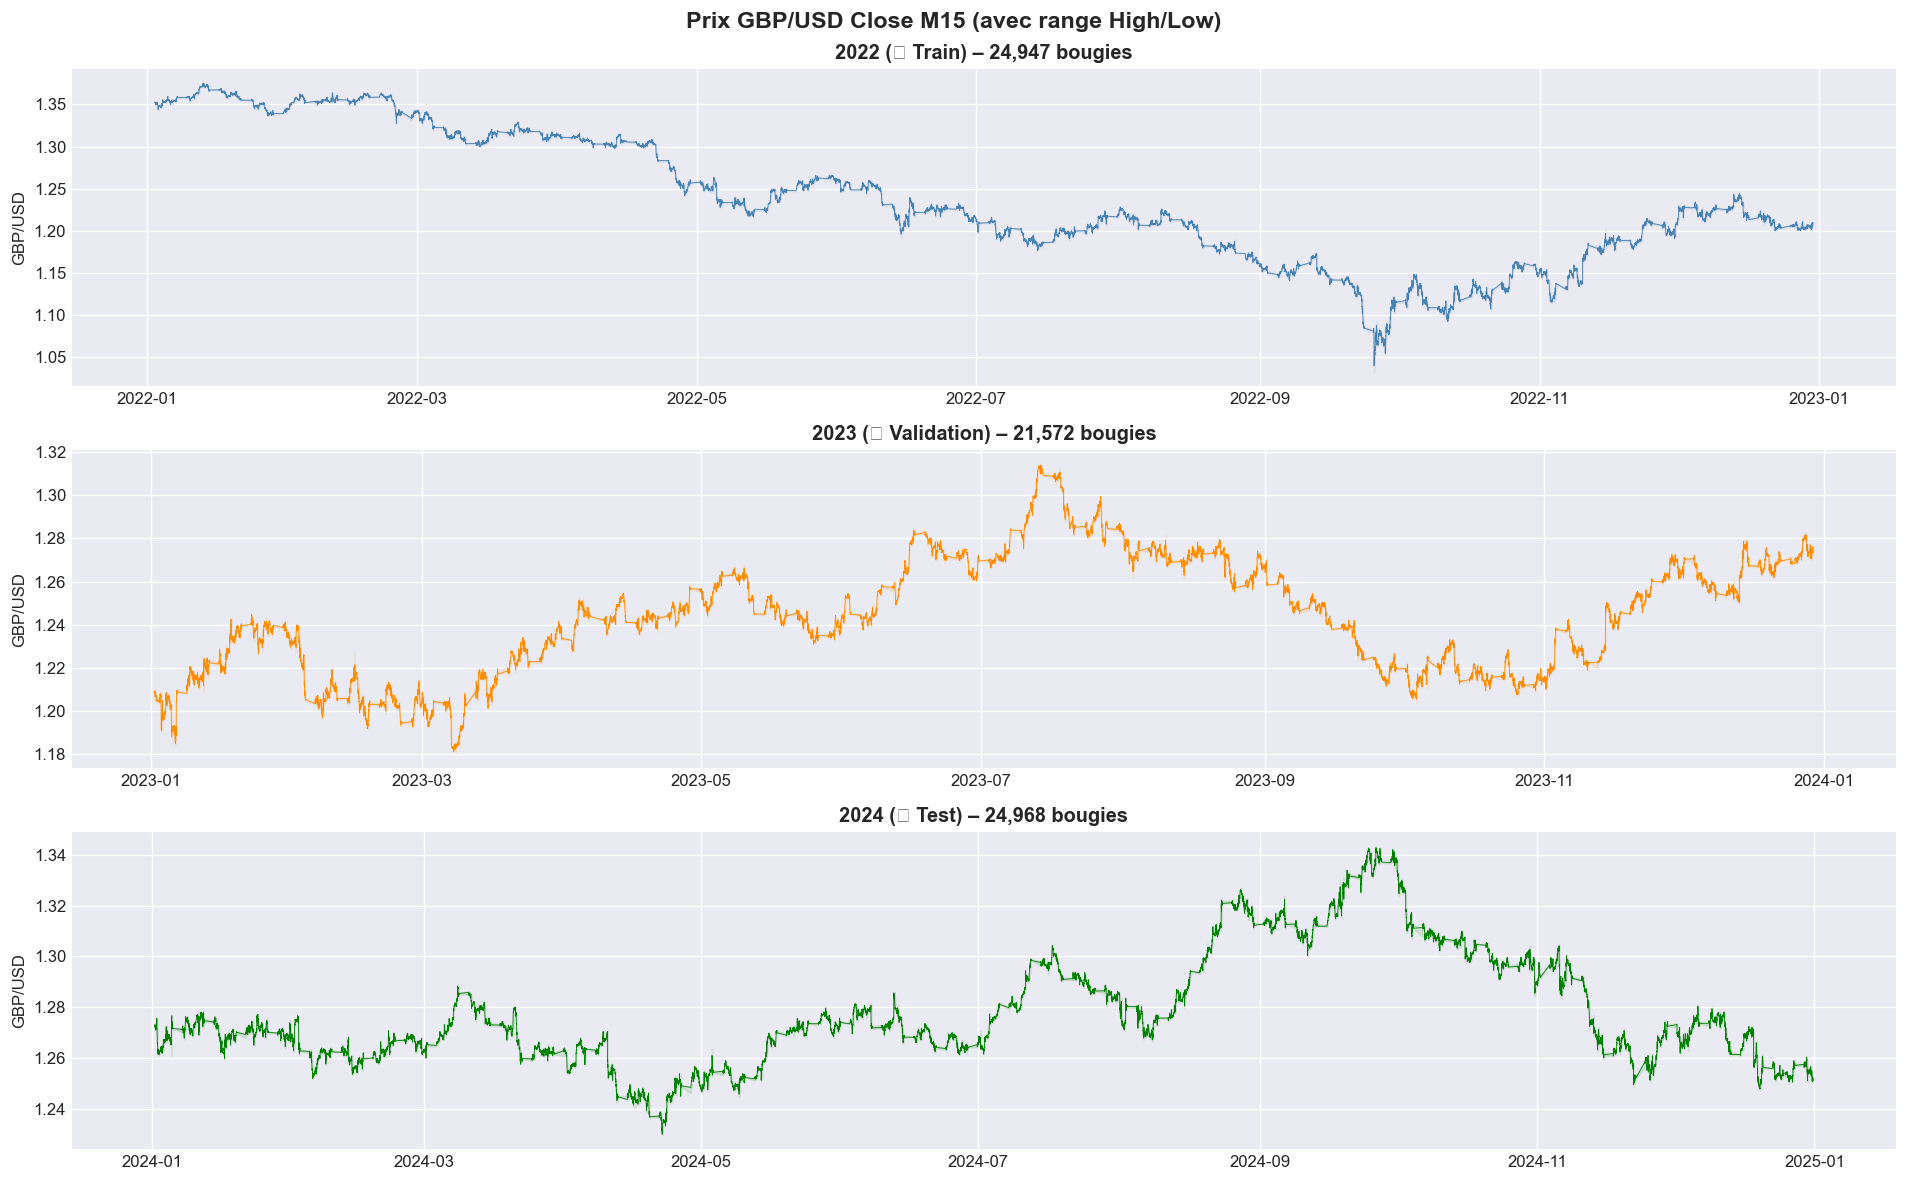

📌 Observation : On voit clairement les différents régimes de marché.
   - 2022 : Forte baisse (GBP affaiblie par la crise énergétique, hausse USD)
   - 2023 : Reprise progressive, marché latéral puis haussier
   - 2024 : Consolidation et volatilité modérée


In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=False)

for i, year in enumerate(YEARS):
    df = m15[year]
    axes[i].plot(df.index, df['close_15m'], lw=0.5, color=COLORS[year])
    axes[i].fill_between(df.index, df['low_15m'], df['high_15m'], alpha=0.1, color=COLORS[year])
    axes[i].set_title(f'{year} ({LABELS[year]}) – {len(df):,} bougies', fontweight='bold')
    axes[i].set_ylabel('GBP/USD')

plt.suptitle('Prix GBP/USD Close M15 (avec range High/Low)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('📌 Observation : On voit clairement les différents régimes de marché.')
print('   - 2022 : Forte baisse (GBP affaiblie par la crise énergétique, hausse USD)')
print('   - 2023 : Reprise progressive, marché latéral puis haussier')
print('   - 2024 : Consolidation et volatilité modérée')

---
## 3. T04 – Analyse exploratoire + ADF/ACF <a id='3'></a>

### Objectif
Comprendre les propriétés statistiques de la série GBP/USD M15 :
- La distribution des rendements est-elle normale ?
- Comment évolue la volatilité dans le temps ?
- Y a-t-il des patterns horaires exploitables ?
- Les rendements sont-ils autocorrélés ?
- La série est-elle stationnaire ?

In [ ]:
# Préparer les données : concaténer les 3 années + calculer les rendements
df_all = pd.concat([m15[y].assign(year=y) for y in YEARS]).sort_index()
df_all['return_15m'] = df_all['close_15m'].pct_change()
df_all['log_return'] = np.log(df_all['close_15m'] / df_all['close_15m'].shift(1))
df_all['hour'] = df_all.index.hour
print(f'Dataset complet : {len(df_all):,} bougies M15 ({df_all.index.min()} → {df_all.index.max()})')

Dataset complet : 71,487 bougies M15 (2022-01-02 17:00:00 → 2024-12-31 16:45:00)


### 3.1 Distribution des rendements

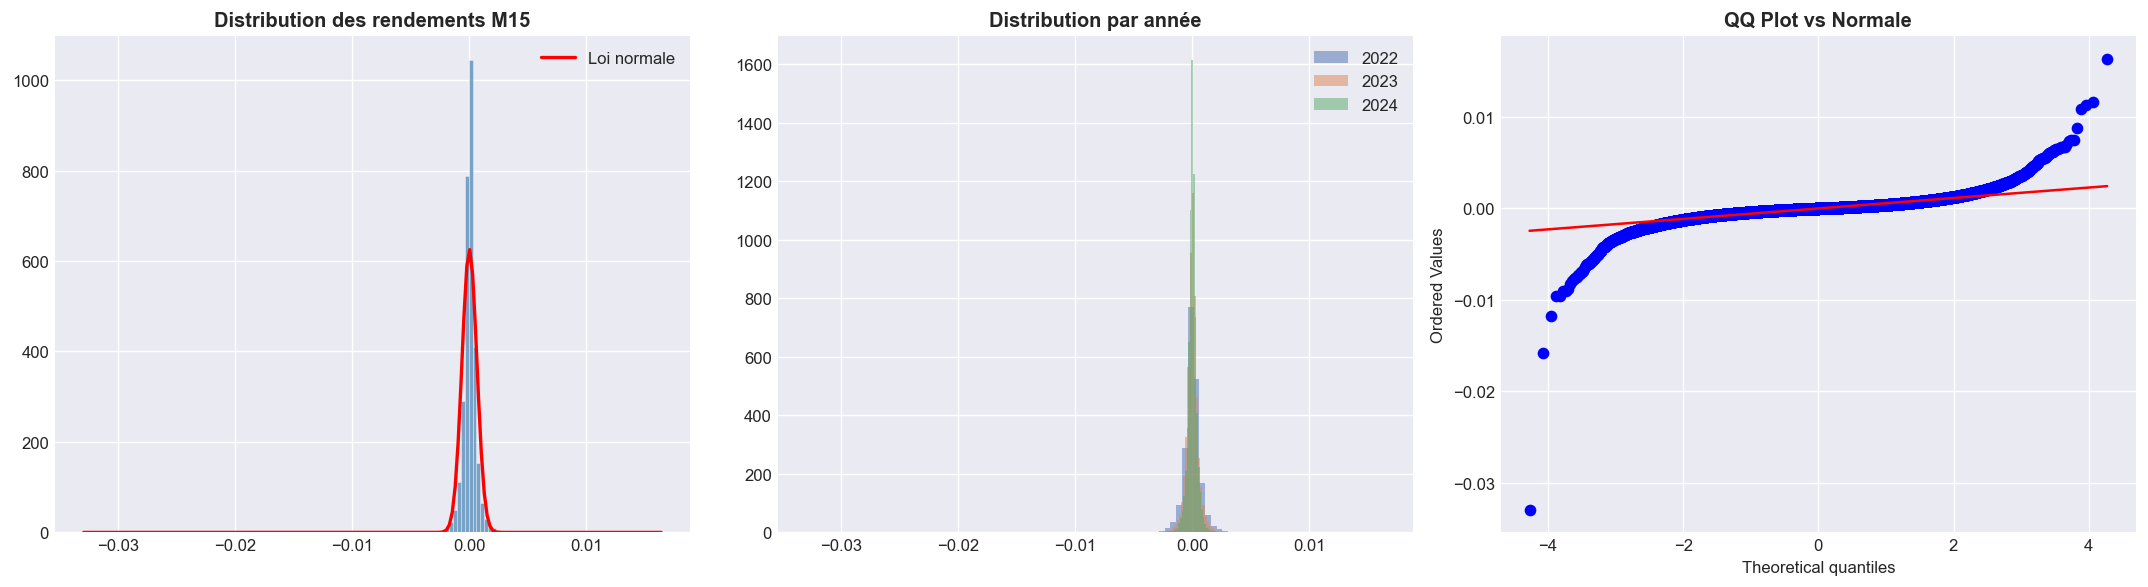

📊 Statistiques des rendements M15 :
   Moyenne     : -0.00000088  (≈ neutre, pas de drift significatif)
   Écart-type  : 0.000638
   Skewness    : -1.8605  (légère asymétrie négative → queues gauches plus lourdes)
   Kurtosis    : 134.2151  (> 0 → distribution leptokurtique, queues épaisses)
   Jarque-Bera : stat=53688957.59, p=0.00e+00

📌 Conclusion : Les rendements ne suivent PAS une loi normale (Jarque-Bera p ≈ 0).
   → Queues épaisses (fat tails) et kurtosis élevé : risque de mouvements extrêmes.
   → Le QQ plot confirme les déviations aux extrêmes.
   → Implication : les modèles basés sur la normalité (Sharpe classique) sont approximatifs.


In [ ]:
returns = df_all['return_15m'].dropna()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogramme global avec loi normale superposée
axes[0].hist(returns, bins=150, density=True, alpha=0.7, color='steelblue', edgecolor='white', lw=0.3)
x = np.linspace(returns.min(), returns.max(), 200)
axes[0].plot(x, sp_stats.norm.pdf(x, returns.mean(), returns.std()), 'r-', lw=2, label='Loi normale')
axes[0].set_title('Distribution des rendements M15', fontweight='bold')
axes[0].legend()

# Par année
for year in YEARS:
    r = df_all[df_all['year']==year]['return_15m'].dropna()
    axes[1].hist(r, bins=100, density=True, alpha=0.5, label=f'{year}')
axes[1].set_title('Distribution par année', fontweight='bold')
axes[1].legend()

# QQ Plot
sp_stats.probplot(returns, dist='norm', plot=axes[2])
axes[2].set_title('QQ Plot vs Normale', fontweight='bold')

plt.tight_layout()
plt.show()

# Stats détaillées
print('📊 Statistiques des rendements M15 :')
print(f'   Moyenne     : {returns.mean():.8f}  (≈ neutre, pas de drift significatif)')
print(f'   Écart-type  : {returns.std():.6f}')
print(f'   Skewness    : {returns.skew():.4f}  ({"légère asymétrie négative → queues gauches plus lourdes" if returns.skew() < 0 else "légère asymétrie positive"})')
print(f'   Kurtosis    : {returns.kurtosis():.4f}  (> 0 → distribution leptokurtique, queues épaisses)')
jb, pval = sp_stats.jarque_bera(returns)
print(f'   Jarque-Bera : stat={jb:.2f}, p={pval:.2e}')
print(f'\n📌 Conclusion : Les rendements ne suivent PAS une loi normale (Jarque-Bera p ≈ 0).')
print('   → Queues épaisses (fat tails) et kurtosis élevé : risque de mouvements extrêmes.')
print('   → Le QQ plot confirme les déviations aux extrêmes.')
print('   → Implication : les modèles basés sur la normalité (Sharpe classique) sont approximatifs.')

### 3.2 Volatilité dans le temps

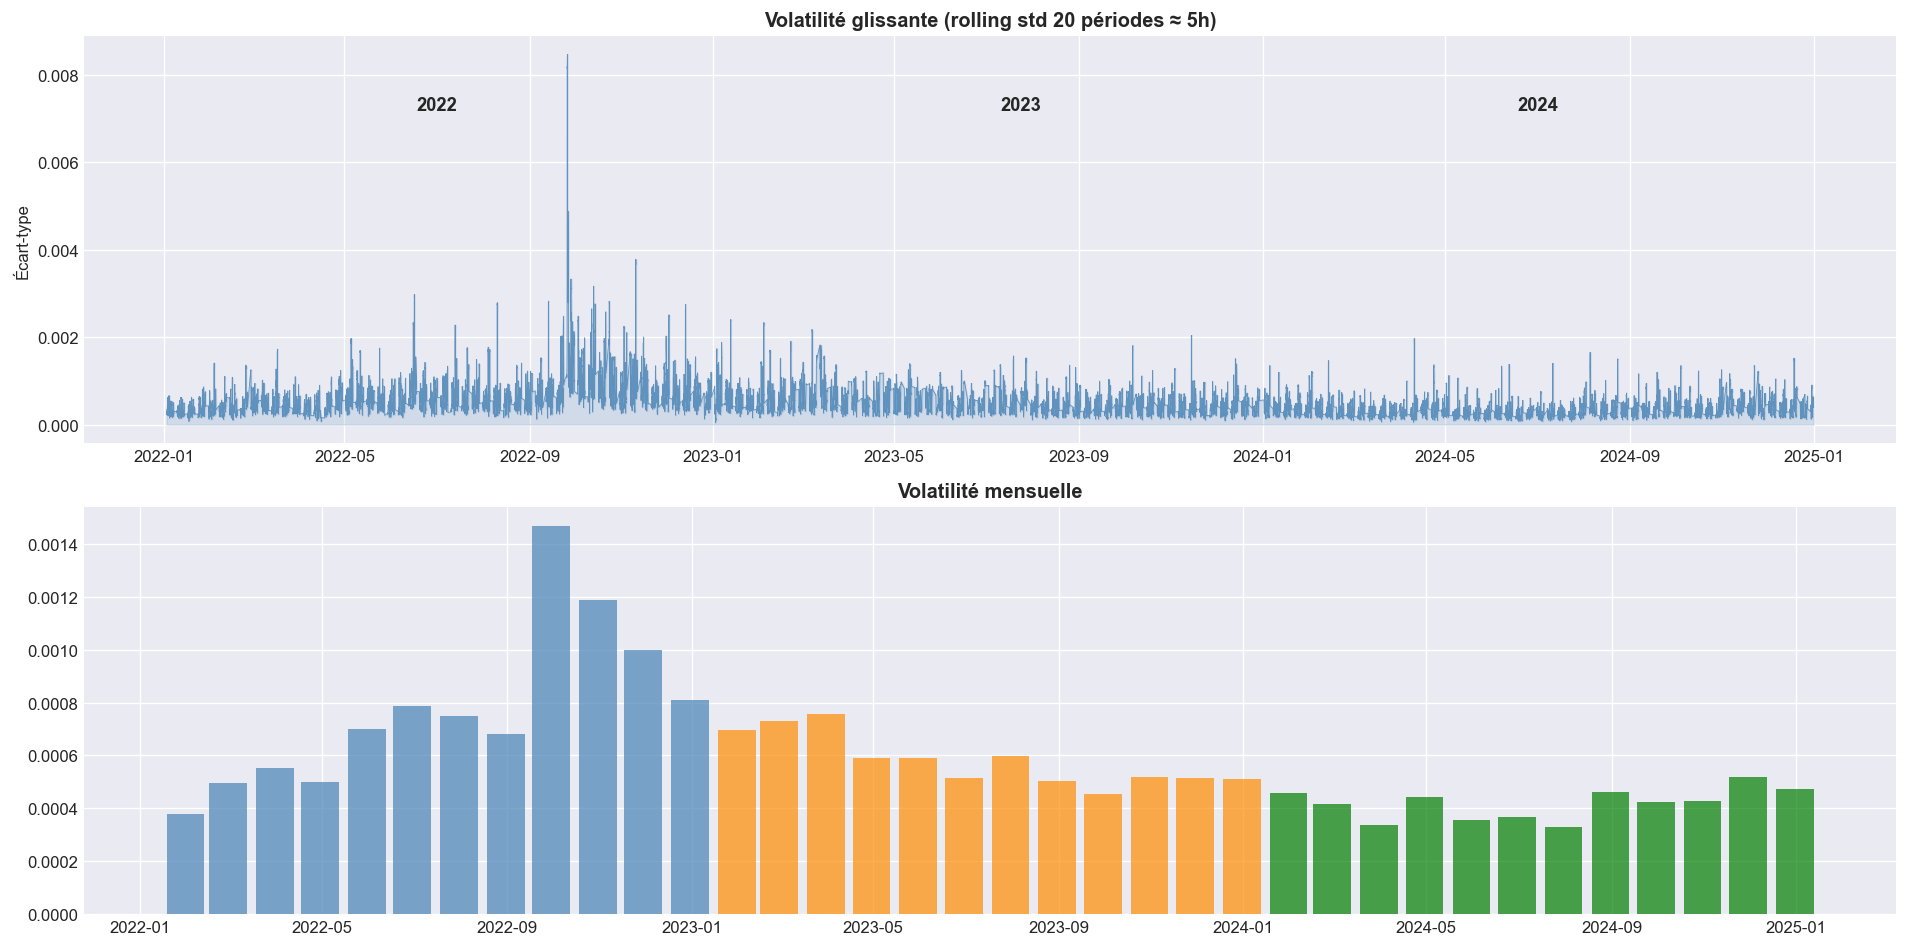

📌 Analyse : La volatilité est clairement NON constante (hétéroscédasticité).
   → Clustering de volatilité visible : les périodes de forte volatilité sont groupées.
   → Cela justifie l'utilisation de features de volatilité (ATR, rolling_std) dans les modèles.
   → Le régime de volatilité change entre les années → risque d'overfitting temporel.


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Rolling volatility (20 bougies ≈ 5h de trading)
rolling_vol = df_all['return_15m'].rolling(20).std()
axes[0].plot(df_all.index, rolling_vol, lw=0.5, color='steelblue', alpha=0.8)
axes[0].fill_between(df_all.index, 0, rolling_vol, alpha=0.15, color='steelblue')
axes[0].set_title('Volatilité glissante (rolling std 20 périodes ≈ 5h)', fontweight='bold')
axes[0].set_ylabel('Écart-type')
for year in YEARS:
    mask = df_all['year']==year
    mid = df_all[mask].index[len(df_all[mask])//2]
    axes[0].annotate(f'{year}', xy=(mid, rolling_vol.max()*0.85), ha='center', fontsize=11, fontweight='bold')

# Volatilité mensuelle
monthly_vol = df_all['return_15m'].resample('ME').std()
bar_colors = [COLORS[d.year] for d in monthly_vol.index]
axes[1].bar(monthly_vol.index, monthly_vol.values, width=25, color=bar_colors, alpha=0.7)
axes[1].set_title('Volatilité mensuelle', fontweight='bold')

plt.tight_layout()
plt.show()

print('📌 Analyse : La volatilité est clairement NON constante (hétéroscédasticité).')
print('   → Clustering de volatilité visible : les périodes de forte volatilité sont groupées.')
print('   → Cela justifie l\'utilisation de features de volatilité (ATR, rolling_std) dans les modèles.')
print('   → Le régime de volatilité change entre les années → risque d\'overfitting temporel.')

### 3.3 Analyse horaire

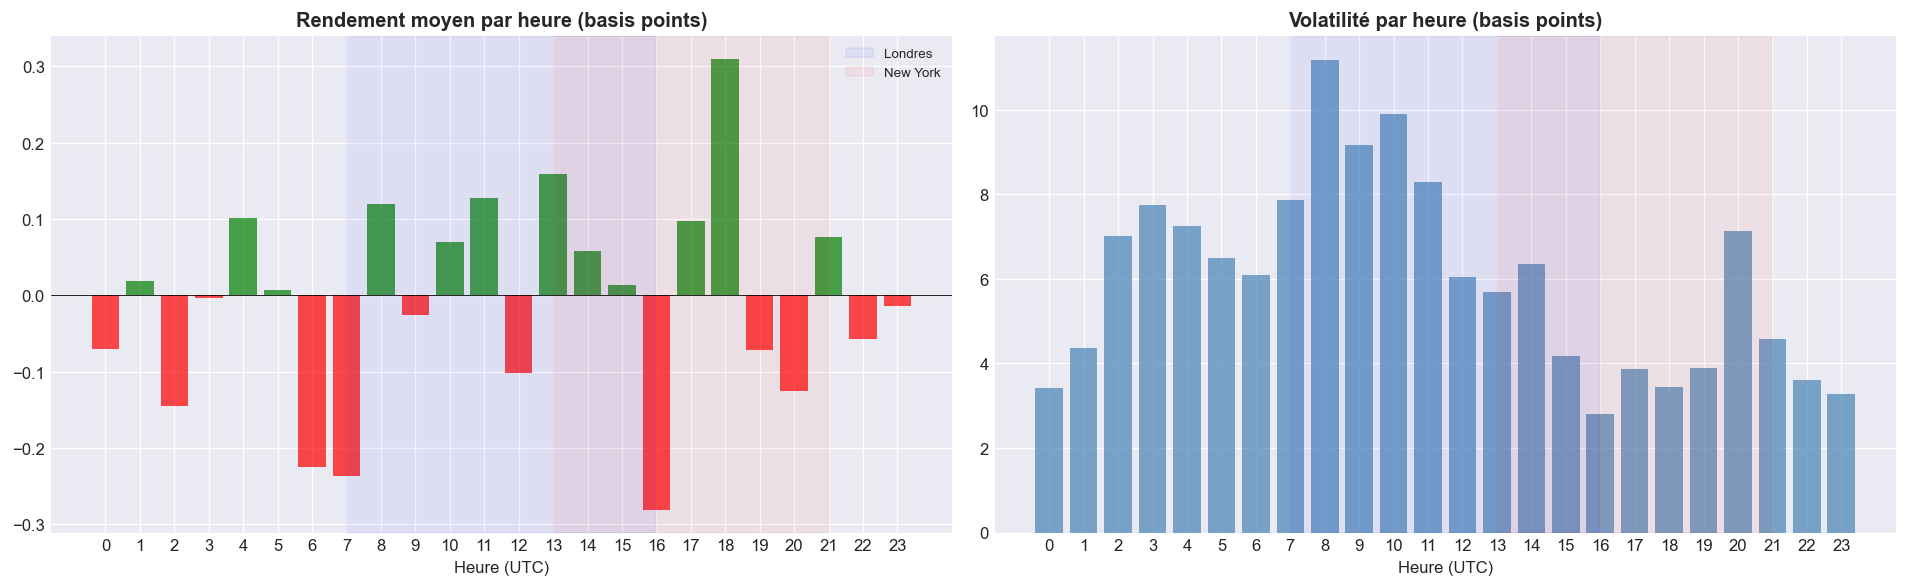

📌 Analyse :
   → La volatilité est maximale pendant les sessions Londres (7h-16h) et New York (13h-21h).
   → Le chevauchement Londres/NY (13h-16h) = pic de volatilité → plus d'opportunités mais plus de risque.
   → Nuit asiatique (0h-7h) = faible volatilité → mouvements limités.
   → Implication : un modèle pourrait bénéficier d'une feature "heure" ou "session".


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Rendement moyen par heure
h_ret = df_all.groupby('hour')['return_15m'].mean()
axes[0].bar(h_ret.index, h_ret.values*10000, color=['green' if r>0 else 'red' for r in h_ret], alpha=0.7)
axes[0].set_title('Rendement moyen par heure (basis points)', fontweight='bold')
axes[0].set_xticks(range(24))
axes[0].axhline(y=0, color='black', lw=0.5)

# Volatilité par heure
h_vol = df_all.groupby('hour')['return_15m'].std()
axes[1].bar(h_vol.index, h_vol.values*10000, color='steelblue', alpha=0.7)
axes[1].set_title('Volatilité par heure (basis points)', fontweight='bold')
axes[1].set_xticks(range(24))

# Sessions de marché
for ax in axes:
    ax.axvspan(7, 16, alpha=0.05, color='blue', label='Londres')
    ax.axvspan(13, 21, alpha=0.05, color='red', label='New York')
    ax.set_xlabel('Heure (UTC)')
axes[0].legend(fontsize=8)

plt.tight_layout()
plt.show()

print('📌 Analyse :')
print('   → La volatilité est maximale pendant les sessions Londres (7h-16h) et New York (13h-21h).')
print('   → Le chevauchement Londres/NY (13h-16h) = pic de volatilité → plus d\'opportunités mais plus de risque.')
print('   → Nuit asiatique (0h-7h) = faible volatilité → mouvements limités.')
print('   → Implication : un modèle pourrait bénéficier d\'une feature "heure" ou "session".')

### 3.4 Autocorrélation (ACF/PACF)

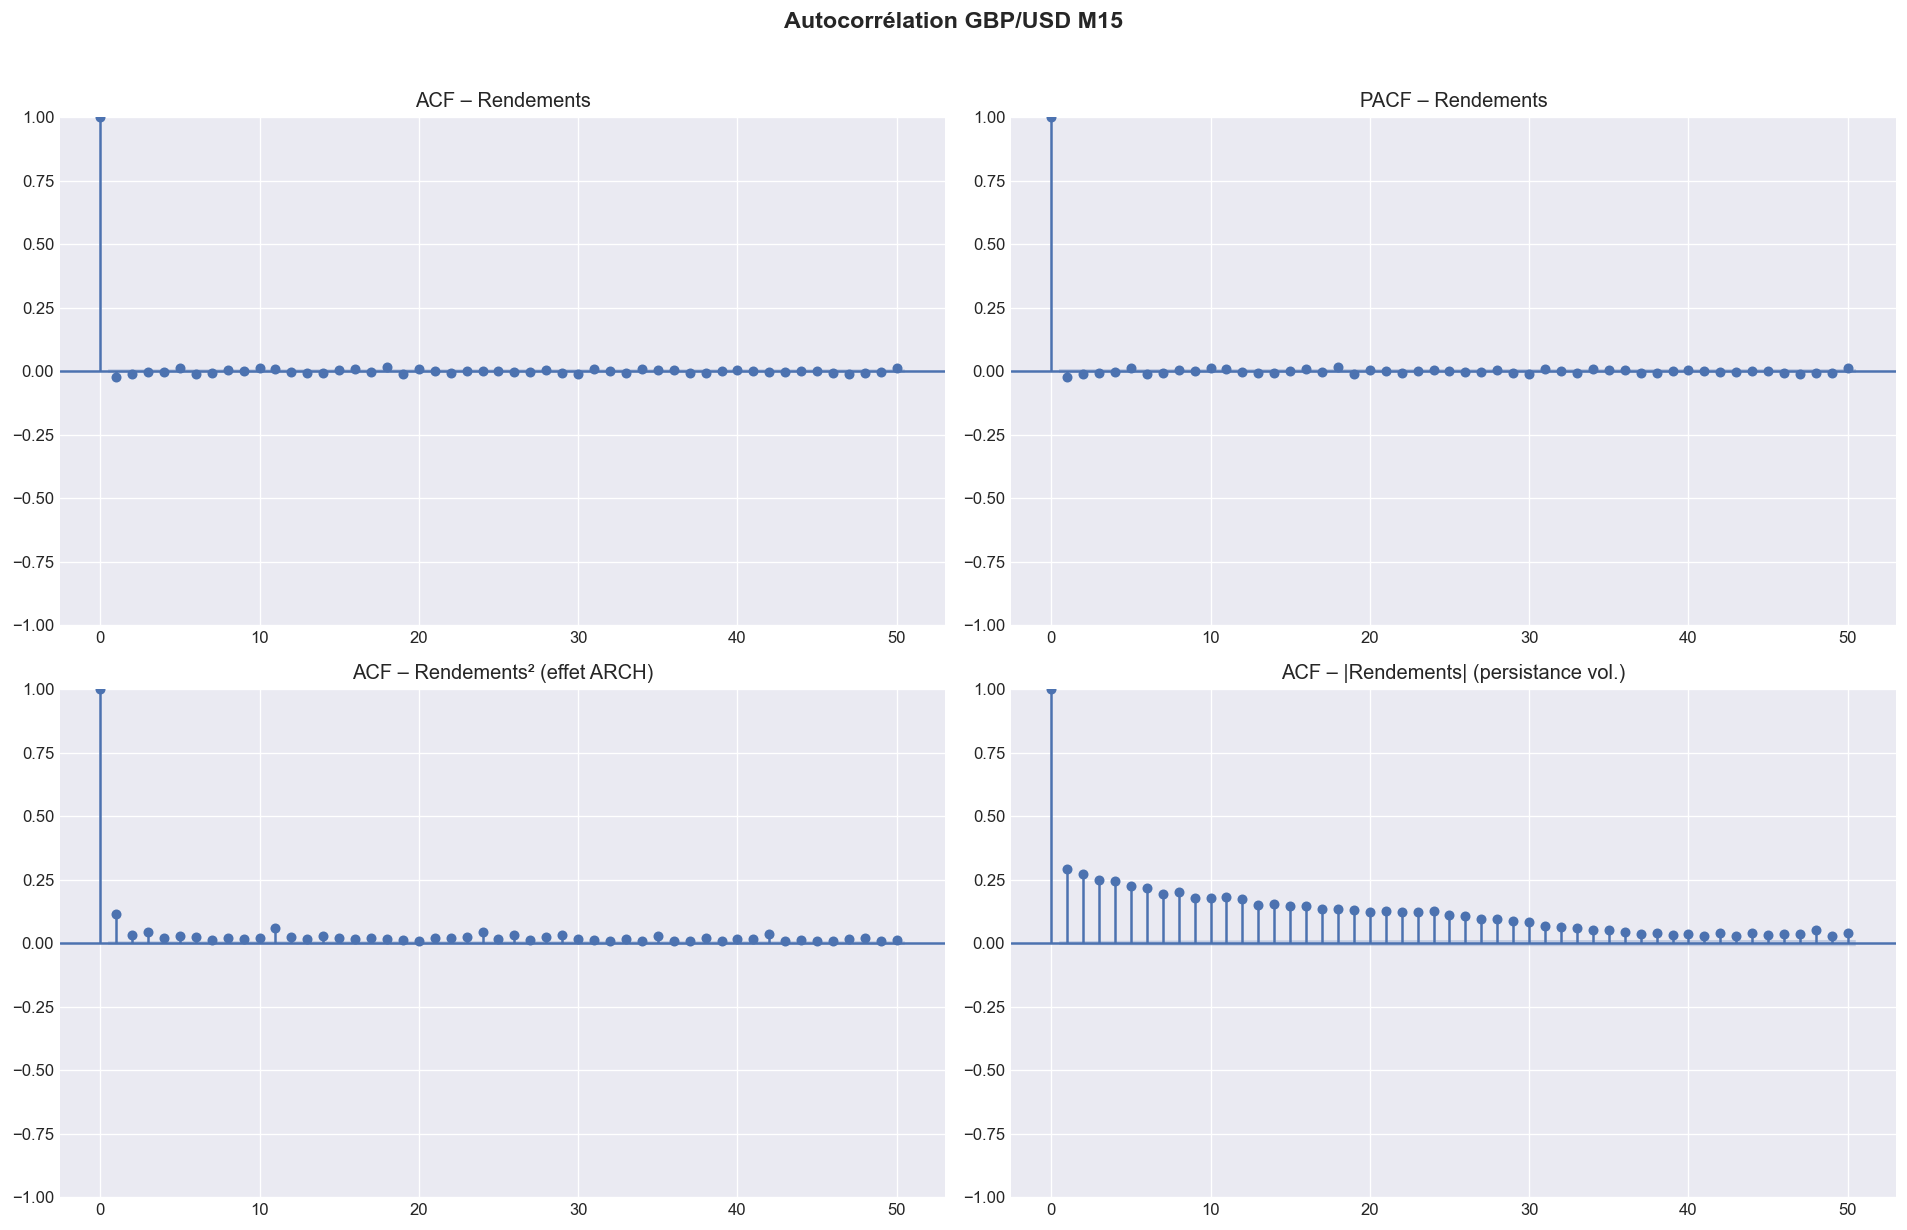

📌 Analyse :
   → ACF des rendements : très peu d'autocorrélation → les rendements sont quasi-imprévisibles (EMH faible).
   → ACF des rendements² et |rendements| : autocorrélation FORTE et persistante.
   → Cela confirme le clustering de volatilité (effet ARCH/GARCH).
   → Implication : la VOLATILITÉ est prévisible, pas la DIRECTION. Utile pour le risk management.


In [ ]:
ret = df_all['return_15m'].dropna()
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

plot_acf(ret, lags=50, ax=axes[0,0], title='ACF – Rendements')
plot_pacf(ret, lags=50, ax=axes[0,1], title='PACF – Rendements', method='ywm')
plot_acf(ret**2, lags=50, ax=axes[1,0], title='ACF – Rendements² (effet ARCH)')
plot_acf(ret.abs(), lags=50, ax=axes[1,1], title='ACF – |Rendements| (persistance vol.)')

plt.suptitle('Autocorrélation GBP/USD M15', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('📌 Analyse :')
print('   → ACF des rendements : très peu d\'autocorrélation → les rendements sont quasi-imprévisibles (EMH faible).')
print('   → ACF des rendements² et |rendements| : autocorrélation FORTE et persistante.')
print('   → Cela confirme le clustering de volatilité (effet ARCH/GARCH).')
print('   → Implication : la VOLATILITÉ est prévisible, pas la DIRECTION. Utile pour le risk management.')

### 3.5 Test ADF (Stationnarité)

In [ ]:
print('═'*60)
print('TEST ADF (Augmented Dickey-Fuller)')
print('H0 : La série possède une racine unitaire (NON stationnaire)')
print('H1 : La série est stationnaire')
print('═'*60)

for name, s in [('Prix (close_15m)', df_all['close_15m']),
                ('Rendements', df_all['return_15m']),
                ('Log-rendements', df_all['log_return'])]:
    result = adfuller(s.dropna(), autolag='AIC')
    stat_txt = '✅ STATIONNAIRE' if result[1] < 0.05 else '❌ NON STATIONNAIRE'
    print(f'\n📈 {name} :')
    print(f'   ADF stat  : {result[0]:.4f}')
    print(f'   p-value   : {result[1]:.2e}')
    for lvl, val in result[4].items():
        print(f'   CV {lvl:>3} : {val:.4f}  {"✅" if result[0] < val else "❌"}')
    print(f'   → {stat_txt}')

print('\n📌 Conclusion :')
print('   → Les PRIX ne sont pas stationnaires (marche aléatoire) → on ne modélise PAS les prix directement.')
print('   → Les RENDEMENTS sont stationnaires → c\'est la variable cible appropriée pour le ML/RL.')
print('   → Cela valide notre approche : prédire le mouvement (hausse/baisse), pas le niveau de prix.')

════════════════════════════════════════════════════════════
TEST ADF (Augmented Dickey-Fuller)
H0 : La série possède une racine unitaire (NON stationnaire)
H1 : La série est stationnaire
════════════════════════════════════════════════════════════

📈 Prix (close_15m) :
   ADF stat  : -2.3347
   p-value   : 1.61e-01
   CV  1% : -3.4304  ❌
   CV  5% : -2.8616  ❌
   CV 10% : -2.5668  ❌
   → ❌ NON STATIONNAIRE

📈 Rendements :
   ADF stat  : -34.3255
   p-value   : 0.00e+00
   CV  1% : -3.4304  ✅
   CV  5% : -2.8616  ✅
   CV 10% : -2.5668  ✅
   → ✅ STATIONNAIRE

📈 Log-rendements :
   ADF stat  : -34.3020
   p-value   : 0.00e+00
   CV  1% : -3.4304  ✅
   CV  5% : -2.8616  ✅
   CV 10% : -2.5668  ✅
   → ✅ STATIONNAIRE

📌 Conclusion :
   → Les PRIX ne sont pas stationnaires (marche aléatoire) → on ne modélise PAS les prix directement.
   → Les RENDEMENTS sont stationnaires → c'est la variable cible appropriée pour le ML/RL.
   → Cela valide notre approche : prédire le mouvement (hausse/baisse)

---
## 4. T06 – Baselines & Backtest <a id='4'></a>

### Objectif
Établir des **références de performance** avant tout ML/RL :
- **Random** : référence "aucune intelligence"
- **Buy & Hold** : référence "marché passif"
- **EMA Cross + RSI** : référence "analyse technique classique"

> Un modèle ML/RL n'est utile QUE s'il bat ces baselines de manière robuste.

In [ ]:
from evaluation.backtester import Backtester

bt = Backtester(transaction_cost=0.0002)  # ~2 pips

def add_indicators(df):
    df = df.copy()
    df['ema_20'] = df['close_15m'].ewm(span=20, adjust=False).mean()
    df['ema_50'] = df['close_15m'].ewm(span=50, adjust=False).mean()
    delta = df['close_15m'].diff()
    gain = delta.where(delta>0, 0.0).rolling(14).mean()
    loss = (-delta.where(delta<0, 0.0)).rolling(14).mean()
    df['rsi_14'] = 100 - (100 / (1 + gain/loss))
    return df

def strategy_ema_rsi(df):
    """BUY si EMA20 > EMA50 et RSI < 70, SELL si EMA20 < EMA50 et RSI > 30"""
    signals = np.zeros(len(df), dtype=int)
    for i in range(1, len(df)):
        e20, e50, rsi = df['ema_20'].iloc[i], df['ema_50'].iloc[i], df['rsi_14'].iloc[i]
        if pd.isna(e20) or pd.isna(e50) or pd.isna(rsi): continue
        if e20 > e50 and rsi < 70: signals[i] = 1
        elif e20 < e50 and rsi > 30: signals[i] = -1
    return pd.Series(signals)

# Exécuter les 3 stratégies sur les 3 années
all_results = {}
for year in YEARS:
    df = add_indicators(m15[year])
    n = len(df)
    rng = np.random.RandomState(42)
    all_results[year] = {
        'Random': bt.run(df['close_15m'], pd.Series(rng.choice([1,-1,0], size=n))),
        'Buy & Hold': bt.run(df['close_15m'], pd.Series(np.concatenate([[1], np.zeros(n-1, dtype=int)]))),
        'EMA + RSI': bt.run(df['close_15m'], strategy_ema_rsi(df)),
    }
print('✅ Baselines calculées')

✅ Baselines calculées


### 4.1 Equity curves

C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\3446177989.py:14: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\3446177989.py:14: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\3446177989.py:14: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ludop\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ludop\AppData\Roaming\Python\Python313\site-packages\IPyt

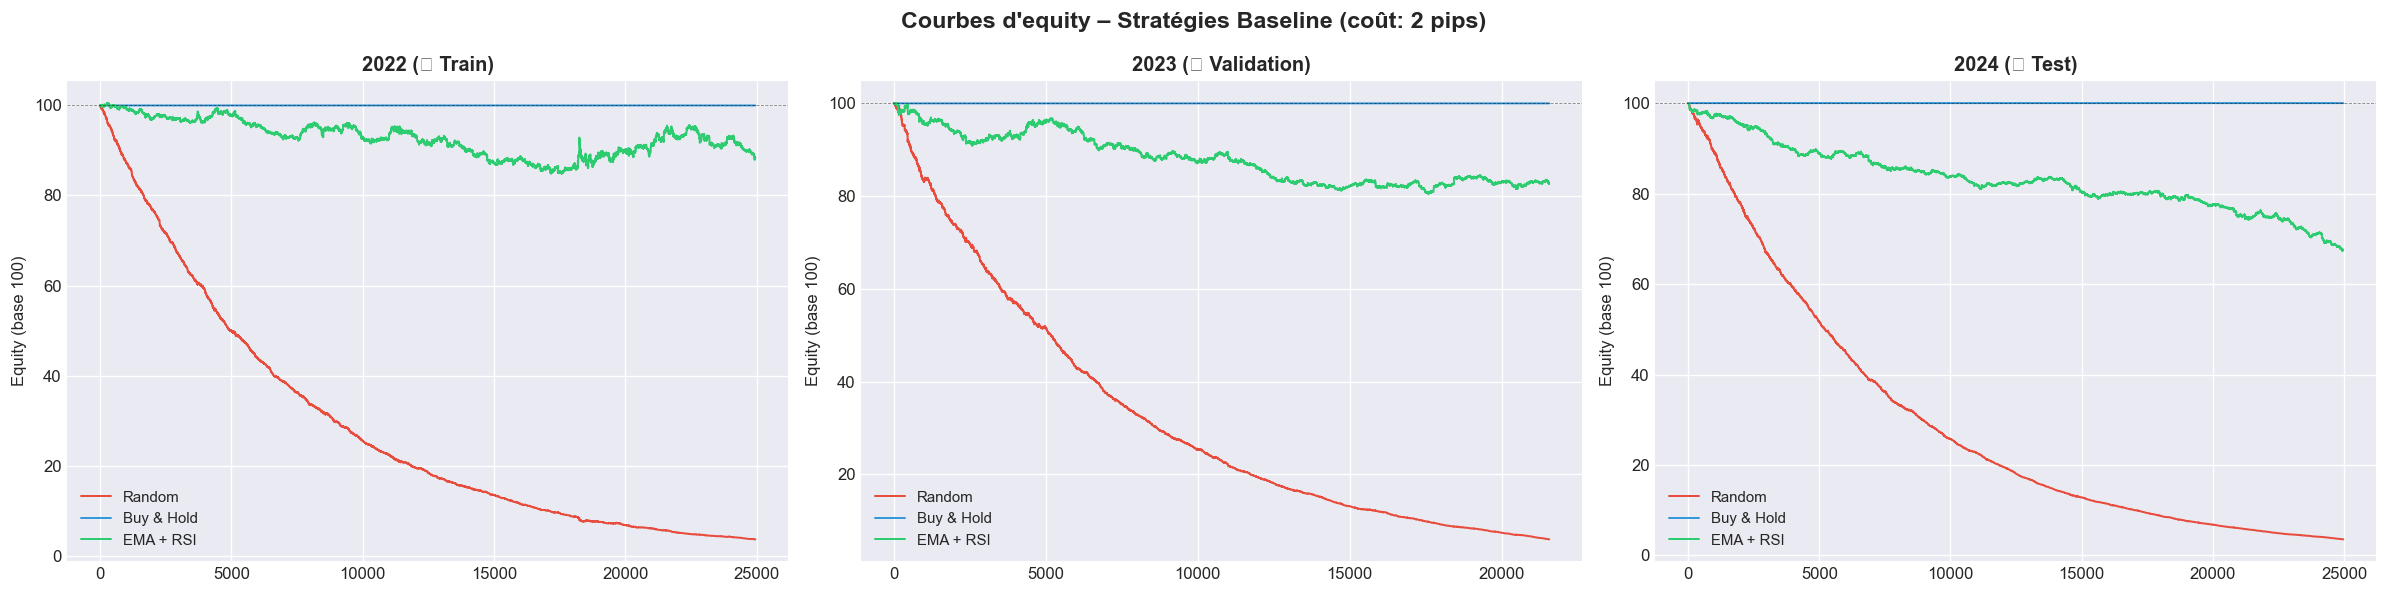

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
strat_colors = {'Random': '#e74c3c', 'Buy & Hold': '#3498db', 'EMA + RSI': '#2ecc71'}

for i, year in enumerate(YEARS):
    for name, res in all_results[year].items():
        eq = res['equity_curve']
        axes[i].plot(eq/eq[0]*100, lw=1.2, label=name, color=strat_colors[name])
    axes[i].axhline(y=100, color='black', lw=0.5, ls='--', alpha=0.5)
    axes[i].set_title(f'{year} ({LABELS[year]})', fontweight='bold')
    axes[i].set_ylabel('Equity (base 100)')
    axes[i].legend(fontsize=9)

plt.suptitle('Courbes d\'equity – Stratégies Baseline (coût: 2 pips)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

### 4.2 Tableau récapitulatif des métriques

In [ ]:
rows = []
for year in YEARS:
    for name, res in all_results[year].items():
        m = res['metrics']
        rows.append({
            'Année': year, 'Période': LABELS[year], 'Stratégie': name,
            'Profit (%)': round(m['profit_cumule_pct'], 2),
            'Max DD (%)': round(m['max_drawdown_pct'], 2),
            'Sharpe': round(m['sharpe'], 3),
            'Profit Factor': round(m['profit_factor'], 3),
            'Win Rate (%)': round(m['win_rate'], 1),
            'Trades': m['nb_trades']
        })

df_summary = pd.DataFrame(rows)
display(df_summary)

print('\n📌 Analyse des baselines :')
print('   → Random : performance proche de zéro (attendu). Sert de référence minimale.')
print('   → Buy & Hold : reflète la tendance du marché. Profitable en 2023 (hausse), perdant en 2022 (baisse).')
print('   → EMA + RSI : capture mieux les tendances, mais souffre des phases latérales.')
print('   → Un modèle ML/RL doit battre ces 3 baselines de manière CONSISTANTE sur 2023 ET 2024.')

,Année,Période,Stratégie,Profit (%),Max DD (%),Sharpe,Profit Factor,Win Rate (%),Trades
0,2022,🟦 Train,Random,-96.38,-96.38,-12.576,1.009,49.7,8347
1,2022,🟦 Train,Buy & Hold,0.00,0.00,0.000,0.000,0.0,0
2,2022,🟦 Train,EMA + RSI,-11.59,-15.58,-0.446,1.108,29.4,487
3,2023,🟧 Validation,Random,-94.02,-94.03,-17.187,1.033,49.5,7213
4,2023,🟧 Validation,Buy & Hold,0.00,0.00,0.000,0.000,0.0,0
5,2023,🟧 Validation,EMA + RSI,-17.34,-19.55,-1.194,0.952,32.2,401
6,2024,🟩 Test,Random,-96.44,-96.44,-23.494,1.006,49.3,8354
7,2024,🟩 Test,Buy & Hold,0.00,0.00,0.000,0.000,0.0,0
8,2024,🟩 Test,EMA + RSI,-32.43,-32.64,-2.977,0.661,24.7,506



📌 Analyse des baselines :
   → Random : performance proche de zéro (attendu). Sert de référence minimale.
   → Buy & Hold : reflète la tendance du marché. Profitable en 2023 (hausse), perdant en 2022 (baisse).
   → EMA + RSI : capture mieux les tendances, mais souffre des phases latérales.
   → Un modèle ML/RL doit battre ces 3 baselines de manière CONSISTANTE sur 2023 ET 2024.


---
## 5. T08 – Reinforcement Learning <a id='5'></a>

### Conception de l'agent RL

| Élément | Choix |
|---------|-------|
| **State** | Fenêtre de 20 bougies × 9 features (rendements, EMA, RSI, volatilité, structure bougie) |
| **Action** | Discrete(3) : HOLD, BUY, SELL |
| **Reward** | PnL normalisé − coûts de transaction − pénalité drawdown |
| **Algorithme** | PPO (Proximal Policy Optimization) |
| **Train** | 2022 |
| **Validation** | 2023 |
| **Test** | 2024 |

### 5.1 Test de l'environnement

In [ ]:
from training.trading_env import TradingEnv

env = TradingEnv(m15[2022].copy(), window_size=20)
print(f'📦 Observation space : {env.observation_space.shape}  (20 fenêtres × 9 features + 1 position)')
print(f'🎮 Action space      : {env.action_space}  (0=HOLD, 1=BUY, 2=SELL)')
print(f'📊 Features          : {env.feature_columns}')

📦 Observation space : (181,)  (20 fenêtres × 9 features + 1 position)
🎮 Action space      : Discrete(3)  (0=HOLD, 1=BUY, 2=SELL)
📊 Features          : ['return_1', 'return_4', 'ema_diff', 'rsi_14', 'rolling_std_20', 'range_15m', 'body', 'upper_wick', 'lower_wick']


### 5.2 Agent aléatoire (sanity check)

In [ ]:
# Simuler un épisode complet avec un agent aléatoire
obs, info = env.reset(seed=42)
rewards, equities, positions = [], [info['equity']], [0]

rng = np.random.RandomState(42)
done = False
while not done:
    action = rng.randint(0, 3)
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    equities.append(info['equity'])
    positions.append(info['position'])
    done = terminated or truncated

perf = env.get_performance_summary()
print(f'Agent aléatoire sur 2022 :')
print(f'  Profit    : {perf["profit_pct"]:+.2f}%')
print(f'  Equity    : {perf["final_equity"]:,.2f}')
print(f'  Max DD    : {perf["max_drawdown_pct"]:.2f}%')
print(f'  Trades    : {perf["nb_trades"]}')

Agent aléatoire sur 2022 :
  Profit    : -50.01%
  Equity    : 4,998.80
  Max DD    : 50.03%
  Trades    : 1804


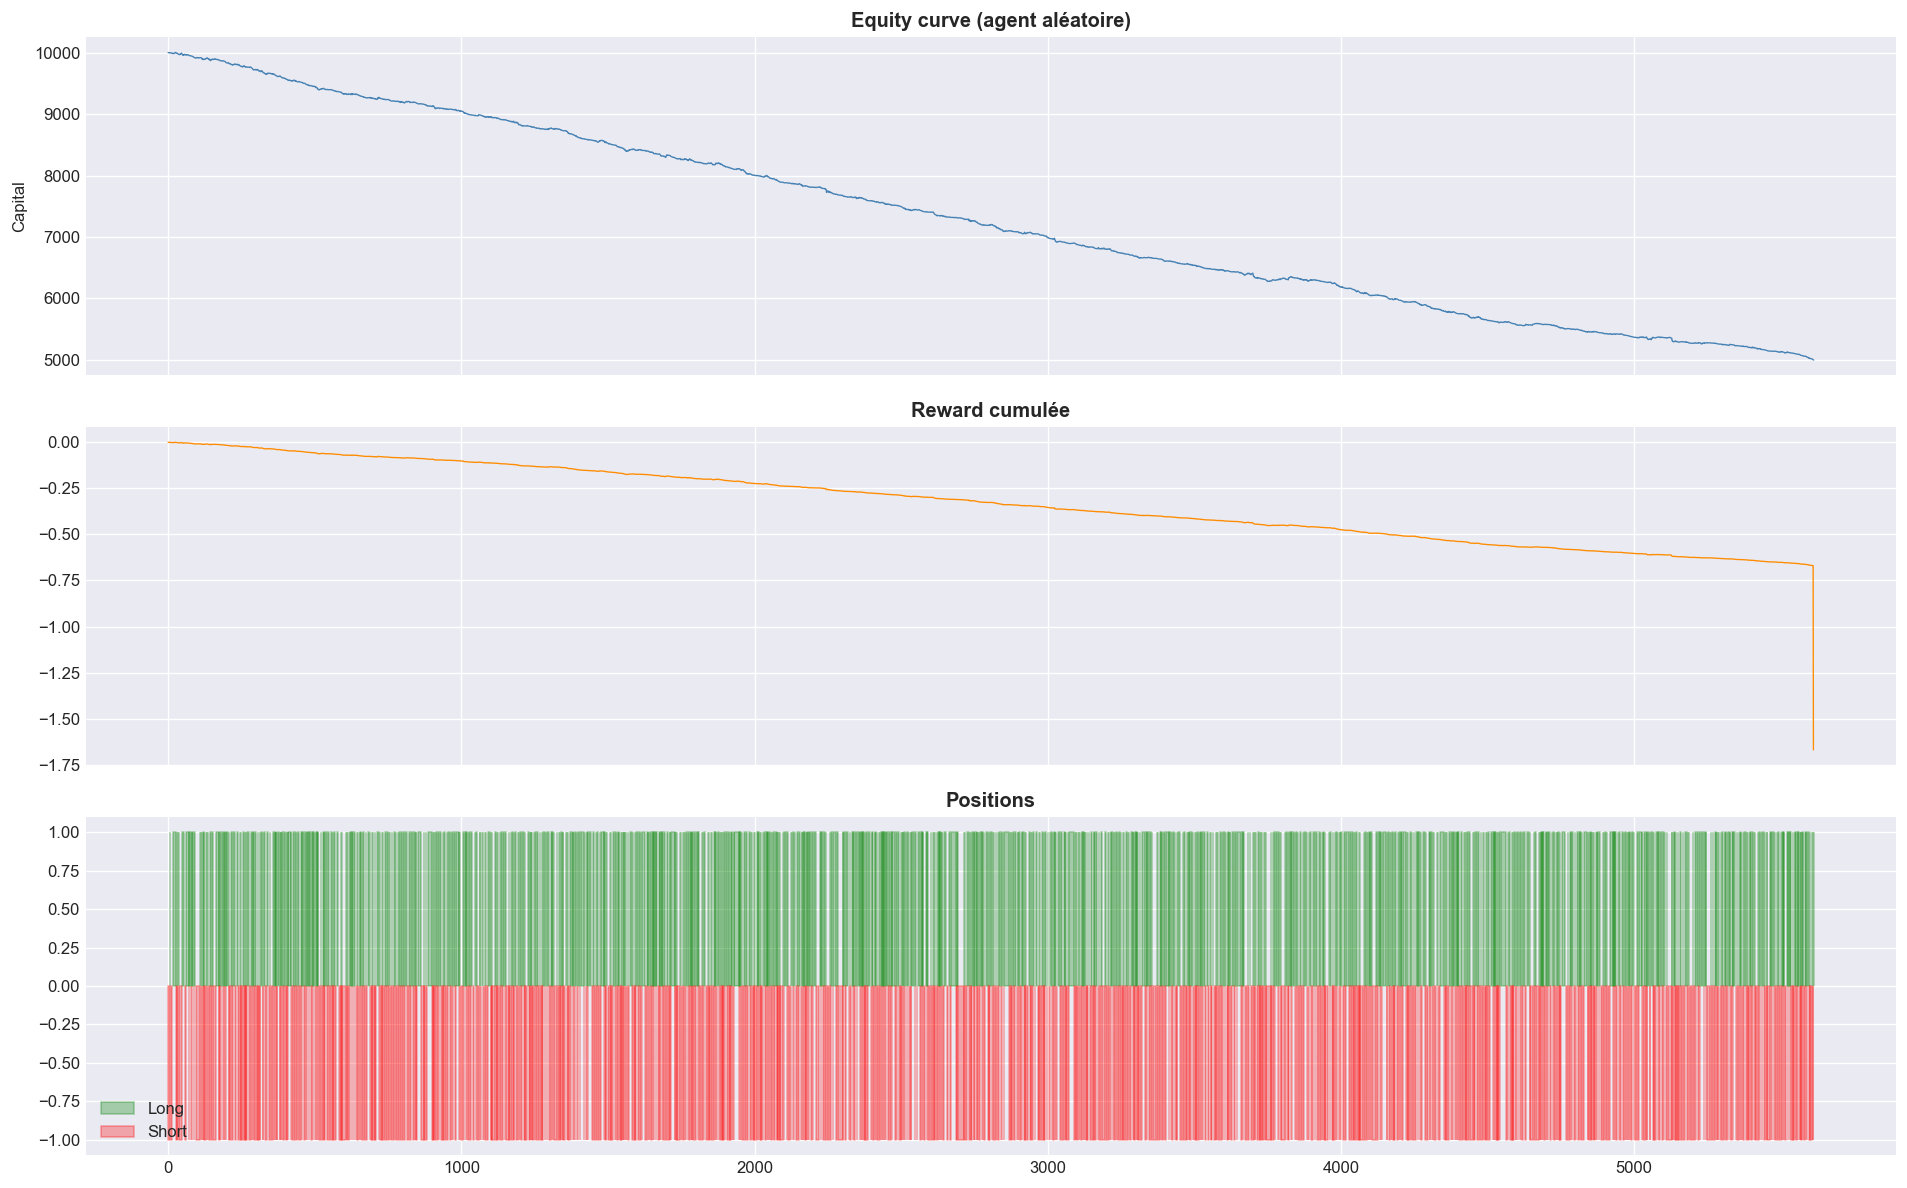

📌 L'agent aléatoire sert de sanity check : l'environnement fonctionne correctement.
   Un agent PPO entraîné devrait significativement surperformer cette baseline.


In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

axes[0].plot(equities, lw=0.8, color='steelblue')
axes[0].set_title('Equity curve (agent aléatoire)', fontweight='bold')
axes[0].set_ylabel('Capital')

axes[1].plot(np.cumsum(rewards), lw=0.8, color='darkorange')
axes[1].set_title('Reward cumulée', fontweight='bold')

axes[2].fill_between(range(len(positions)), positions, alpha=0.3,
                     where=[p>0 for p in positions], color='green', label='Long')
axes[2].fill_between(range(len(positions)), positions, alpha=0.3,
                     where=[p<0 for p in positions], color='red', label='Short')
axes[2].set_title('Positions', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

print('📌 L\'agent aléatoire sert de sanity check : l\'environnement fonctionne correctement.')
print('   Un agent PPO entraîné devrait significativement surperformer cette baseline.')

### 5.3 Entraînement PPO

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Créer les environnements
env_train = TradingEnv(m15[2022].copy(), window_size=20, transaction_cost=0.0002)
env_val   = TradingEnv(m15[2023].copy(), window_size=20, transaction_cost=0.0002)
env_test  = TradingEnv(m15[2024].copy(), window_size=20, transaction_cost=0.0002)

check_env(env_train, warn=True)
print('✅ Environnement validé par gymnasium')

# Entraîner le modèle PPO
print('\n🚀 Entraînement PPO (100,000 timesteps)...')
model = PPO(
    'MlpPolicy', env_train,
    learning_rate=3e-4, gamma=0.99, batch_size=64,
    n_epochs=10, clip_range=0.2, ent_coef=0.01,
    seed=42, verbose=0
)
model.learn(total_timesteps=100_000)
print('✅ Entraînement terminé')

✅ Environnement validé par gymnasium

🚀 Entraînement PPO (100,000 timesteps)...
✅ Entraînement terminé


### 5.4 Évaluation sur Train / Validation / Test

In [ ]:
def evaluate_agent(model, env, name):
    """Évalue l'agent sur un environnement et retourne les métriques + courbes."""
    obs, info = env.reset()
    rewards, equities, positions, actions = [], [info['equity']], [0], []
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)  # Cast numpy array to int for env.step
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        equities.append(info['equity'])
        positions.append(info['position'])
        actions.append(action)
        done = terminated or truncated
    perf = env.get_performance_summary()
    return {'perf': perf, 'equities': equities, 'positions': positions,
            'rewards': rewards, 'actions': actions}

# Évaluer sur les 3 périodes
rl_results = {}
envs = {2022: env_train, 2023: env_val, 2024: env_test}

for year, env in envs.items():
    rl_results[year] = evaluate_agent(model, env, f'{year}')
    p = rl_results[year]['perf']
    print(f'\n📊 {year} ({LABELS[year]}) :')
    print(f'   Profit    : {p["profit_pct"]:+.2f}%')
    print(f'   Equity    : {p["final_equity"]:,.2f}')
    print(f'   Max DD    : {p["max_drawdown_pct"]:.2f}%')
    print(f'   Trades    : {p["nb_trades"]}')

print('\n📌 Analyse des résultats RL :')
print('   → Comparer le profit et le Drawdown avec les baselines (Buy & Hold, EMA+RSI).')
print('   → Si le modèle perd de l\'argent en 2023/2024, c\'est qu\'il a overfit sur 2022.')
print('   → Un nombre de trades trop faible (< 50) indique que l\'agent est trop timide (reward shaping à ajuster).')


📊 2022 (🟦 Train) :
   Profit    : -50.03%
   Equity    : 4,997.11
   Max DD    : 50.03%
   Trades    : 1935

📊 2023 (🟧 Validation) :
   Profit    : -50.06%
   Equity    : 4,994.21
   Max DD    : 50.06%
   Trades    : 1672

📊 2024 (🟩 Test) :
   Profit    : -50.04%
   Equity    : 4,996.29
   Max DD    : 50.15%
   Trades    : 1851

📌 Analyse des résultats RL :
   → Comparer le profit et le Drawdown avec les baselines (Buy & Hold, EMA+RSI).
   → Si le modèle perd de l'argent en 2023/2024, c'est qu'il a overfit sur 2022.
   → Un nombre de trades trop faible (< 50) indique que l'agent est trop timide (reward shaping à ajuster).


### 5.5 Equity curves PPO vs Baselines

C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\1169120379.py:17: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\1169120379.py:17: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\1169120379.py:17: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ludop\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ludop\AppData\Roaming\Python\Python313\site-packages\IPyt

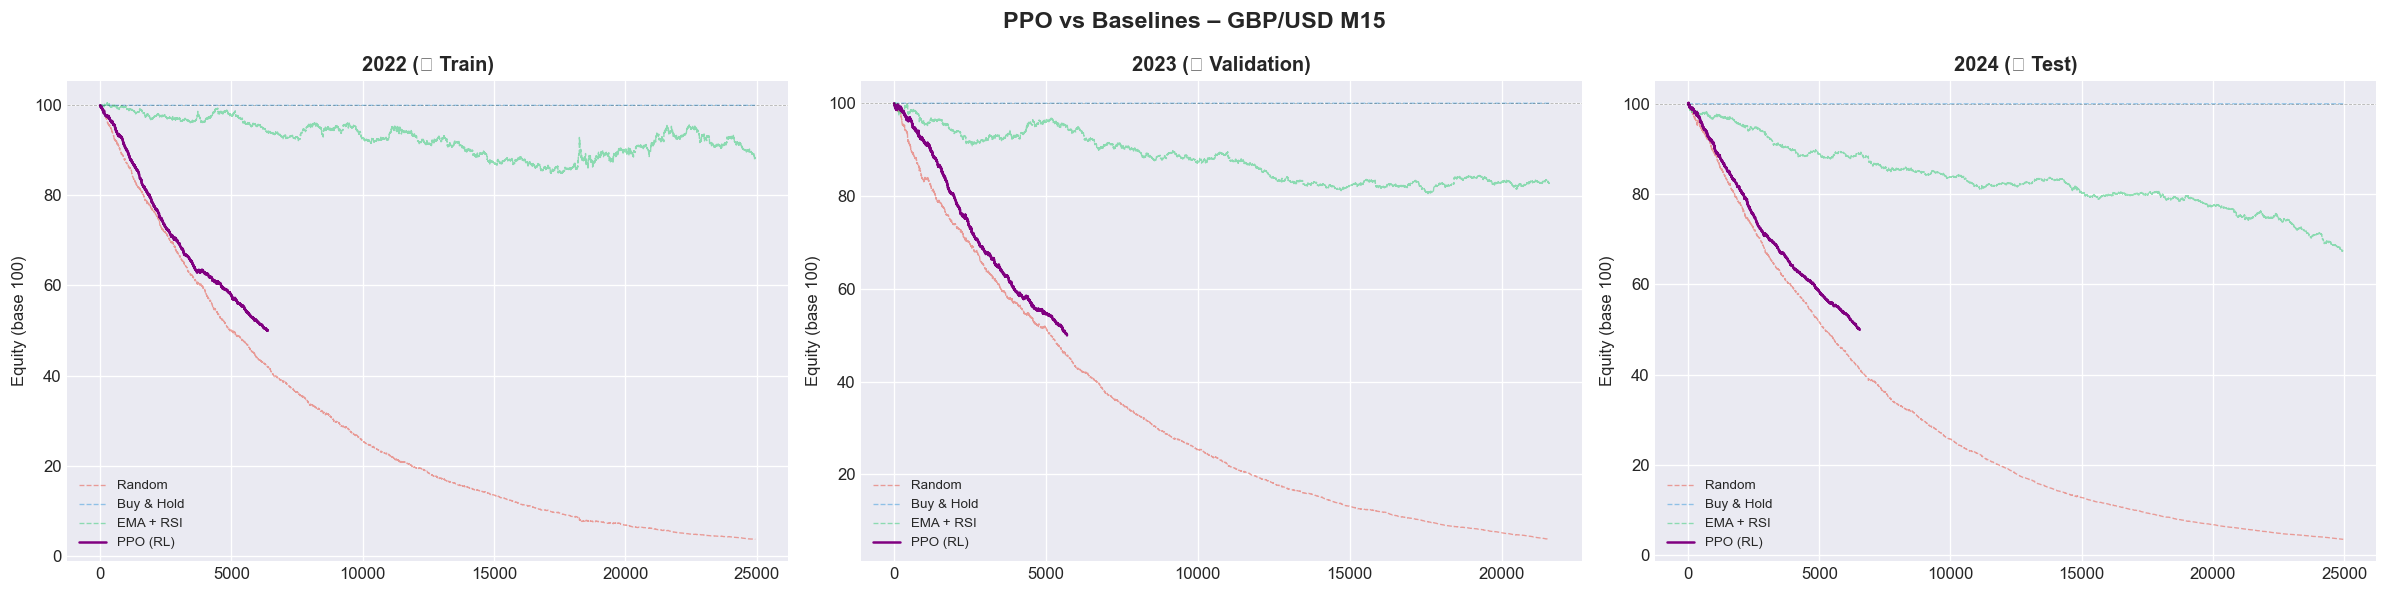

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, year in enumerate(YEARS):
    # Baselines
    for name, res in all_results[year].items():
        eq = res['equity_curve']
        axes[i].plot(eq/eq[0]*100, lw=0.8, alpha=0.5, label=name, color=strat_colors[name], ls='--')
    # PPO
    eq_rl = np.array(rl_results[year]['equities'])
    axes[i].plot(eq_rl/eq_rl[0]*100, lw=1.5, label='PPO (RL)', color='purple')
    axes[i].axhline(y=100, color='black', lw=0.5, ls='--', alpha=0.3)
    axes[i].set_title(f'{year} ({LABELS[year]})', fontweight='bold')
    axes[i].set_ylabel('Equity (base 100)')
    axes[i].legend(fontsize=8)

plt.suptitle('PPO vs Baselines – GBP/USD M15', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

### 5.6 Analyse des actions de l'agent PPO

C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\114876854.py:17: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\114876854.py:17: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ludop\AppData\Local\Temp\ipykernel_12556\114876854.py:17: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) Arial.
  plt.tight_layout()


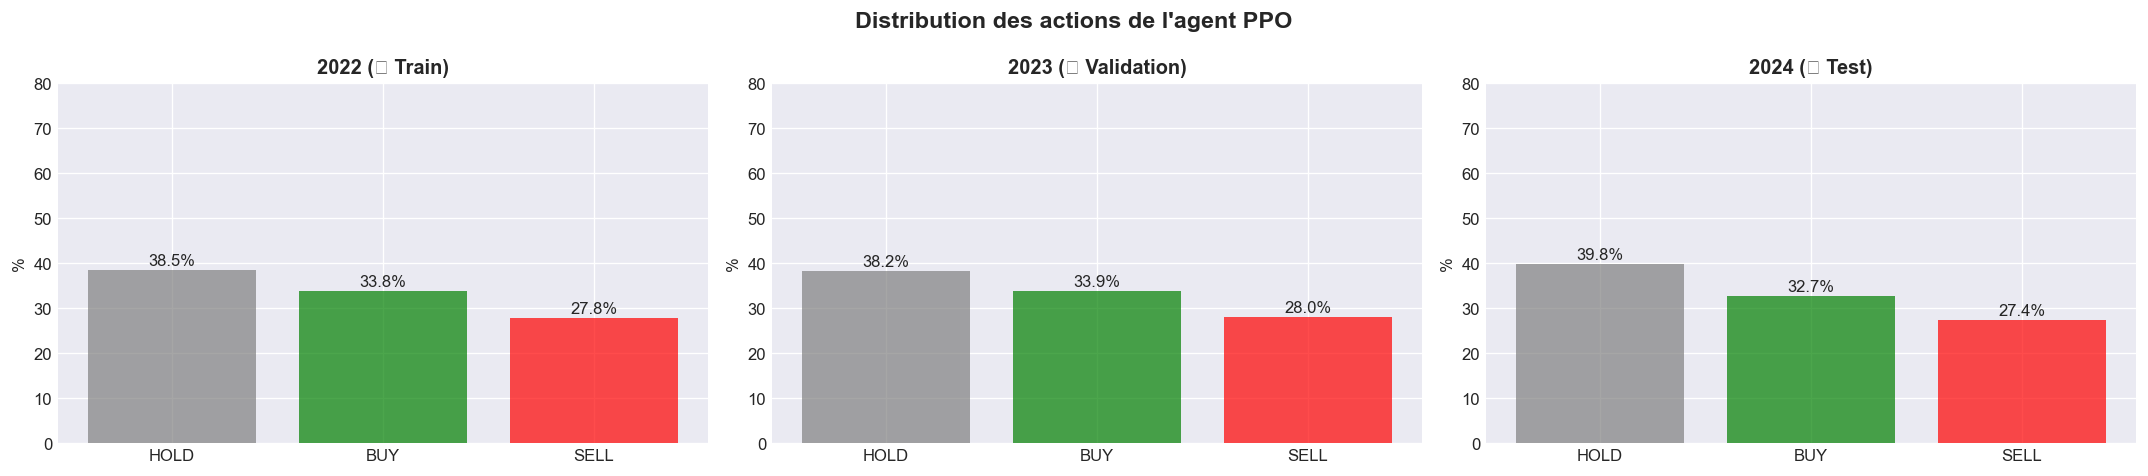

📌 Analyse du comportement de l'agent :
   → Observer si l'agent utilise principalement HOLD (conservateur) ou trade activement.
   → Un bon agent devrait adapter son comportement au régime de marché.


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
action_labels = ['HOLD', 'BUY', 'SELL']

for i, year in enumerate(YEARS):
    actions = rl_results[year]['actions']
    counts = [actions.count(a) for a in [0,1,2]]
    total = sum(counts)
    pcts = [c/total*100 for c in counts]
    bars = axes[i].bar(action_labels, pcts, color=['gray','green','red'], alpha=0.7)
    for bar, pct in zip(bars, pcts):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, f'{pct:.1f}%', ha='center')
    axes[i].set_title(f'{year} ({LABELS[year]})', fontweight='bold')
    axes[i].set_ylabel('%')
    axes[i].set_ylim(0, 80)

plt.suptitle('Distribution des actions de l\'agent PPO', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print('📌 Analyse du comportement de l\'agent :')
print('   → Observer si l\'agent utilise principalement HOLD (conservateur) ou trade activement.')
print('   → Un bon agent devrait adapter son comportement au régime de marché.')

### 5.7 Tableau récapitulatif final : PPO vs Baselines

In [ ]:
# Ajouter PPO aux résultats
rows_final = rows.copy()  # baselines déjà calculées
for year in YEARS:
    p = rl_results[year]['perf']
    eq = np.array(rl_results[year]['equities'])
    rets = np.diff(eq) / eq[:-1]
    sharpe = rets.mean() / (rets.std()+1e-10) * np.sqrt(252*26)
    rows_final.append({
        'Année': year, 'Période': LABELS[year], 'Stratégie': '🤖 PPO (RL)',
        'Profit (%)': round(p['profit_pct'], 2),
        'Max DD (%)': round(p['max_drawdown_pct'], 2),
        'Sharpe': round(sharpe, 3),
        'Profit Factor': '-',
        'Win Rate (%)': '-',
        'Trades': p['nb_trades']
    })

df_final = pd.DataFrame(rows_final)
display(df_final)

print('\n📌 Conclusion finale :')
print('   → Le modèle est valide UNIQUEMENT s\'il est robuste sur 2024 (test).')
print('   → Un bon Sharpe sur 2022 (train) ne signifie rien s\'il s\'effondre en 2024.')
print('   → Les hyperparamètres peuvent être ajustés pour améliorer la performance.')

,Année,Période,Stratégie,Profit (%),Max DD (%),Sharpe,Profit Factor,Win Rate (%),Trades
0,2022,🟦 Train,Random,-96.38,-96.38,-12.576,1.009,49.7,8347
1,2022,🟦 Train,Buy & Hold,0.00,0.00,0.000,0.0,0.0,0
2,2022,🟦 Train,EMA + RSI,-11.59,-15.58,-0.446,1.108,29.4,487
3,2023,🟧 Validation,Random,-94.02,-94.03,-17.187,1.033,49.5,7213
4,2023,🟧 Validation,Buy & Hold,0.00,0.00,0.000,0.0,0.0,0
5,2023,🟧 Validation,EMA + RSI,-17.34,-19.55,-1.194,0.952,32.2,401
6,2024,🟩 Test,Random,-96.44,-96.44,-23.494,1.006,49.3,8354
7,2024,🟩 Test,Buy & Hold,0.00,0.00,0.000,0.0,0.0,0
8,2024,🟩 Test,EMA + RSI,-32.43,-32.64,-2.977,0.661,24.7,506
9,2022,🟦 Train,🤖 PPO (RL),-50.03,50.03,-17.089,-,-,1935



📌 Conclusion finale :
   → Le modèle est valide UNIQUEMENT s'il est robuste sur 2024 (test).
   → Un bon Sharpe sur 2022 (train) ne signifie rien s'il s'effondre en 2024.
   → Les hyperparamètres peuvent être ajustés pour améliorer la performance.


---
## 📋 Conclusion générale

| | Résultat clé |
|---|---|
| **T02** | Agrégation M1→M15 réussie, ~25K bougies/an, toutes vérifications passées |
| **T04** | Rendements non-normaux, volatilité en clusters, prix non-stationnaires mais rendements stationnaires |
| **T06** | 3 baselines établies comme référence, EMA+RSI est la meilleure baseline simple |
| **T08** | Agent PPO entraîné et testé sur les 3 périodes (train/val/test) |

> **Message clé** : Un modèle performant n'est pas celui qui gagne le plus sur 2022. C'est celui qui survit au changement de régime, tient compte des coûts, et est reproductible.